In [96]:
%matplotlib inline

In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

In [98]:
sns.set_theme(style="darkgrid", context="talk")
plt.style.use("dark_background")
plt.rcParams.update({"grid.linewidth":0.45, "grid.alpha":0.5}) 

In [99]:
def set_df(df):
    df.index = pd.to_datetime(df.timestamp)
    df.drop(labels='timestamp',axis=1,inplace=True)

    for col in df:
        df[col] = df[col]-np.mean(df[col])
        df[col] = df[col]/np.std(df[col])
    return df

In [ ]:


df_sensor_one = pd.read_csv(r"E:\Projects\Vibration Sensing Touch Panel\data\region3_ten_taps\SENSOR0_data.csv")
df_sensor_two = pd.read_csv(r"E:\Projects\Vibration Sensing Touch Panel\data\region3_ten_taps\SENSOR1_data.csv")


df_sensor_one = set_df(df_sensor_one)
df_sensor_two = set_df(df_sensor_two)

std_dev_one = np.std(df_sensor_one['z'])
std_dev_two = np.std(df_sensor_two['z'])

df_sensor_two['taps'] = (~((df_sensor_two['z'] <= 2*std_dev_two)&(df_sensor_two['z'] >= -2*std_dev_two))).apply(int)
df_sensor_one['taps'] = (~((df_sensor_one['z'] <= 2*std_dev_one)&(df_sensor_one['z'] >= -2*std_dev_one))).apply(int)

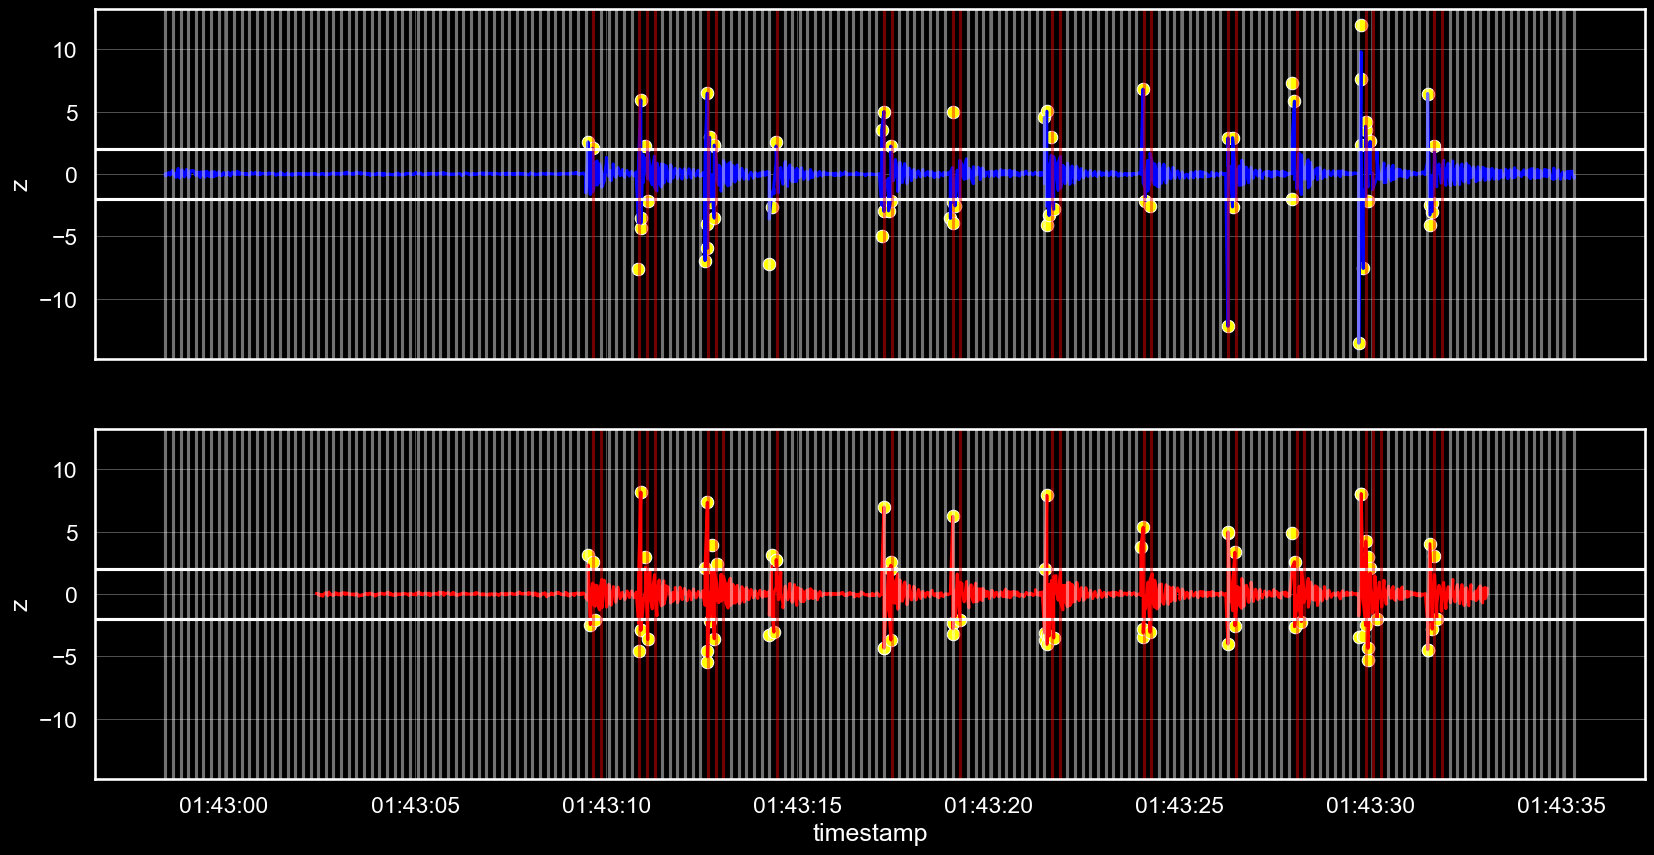

In [101]:
#checking if fixed window is the correct approach

fig,ax = plt.subplots(2,figsize = (20,10),sharex='all',sharey='all')

sns.lineplot(x = df_sensor_one.index,y = df_sensor_one['z'],errorbar=None,color="blue",ax=ax[0]) #ci none cuts down on rendering time when using seaborn!!
sns.lineplot(x = df_sensor_two.index,y = df_sensor_two['z'],errorbar=None,color="red",ax=ax[1])

ax[0].axhline(y = 2*std_dev_one)
ax[0].axhline(y = -2*std_dev_one)

ax[1].axhline(y = 2*std_dev_two)
ax[1].axhline(y = -2*std_dev_two)

df_new_two = pd.DataFrame(df_sensor_two['z'][~((df_sensor_two['z'] <= 2*std_dev_two)&(df_sensor_two['z'] >= -2*std_dev_two))])
df_new_one = pd.DataFrame(df_sensor_one['z'][~((df_sensor_one['z'] <= 2*std_dev_one)&(df_sensor_one['z'] >= -2*std_dev_one))])


sns.scatterplot(x = df_new_two.index,y = df_new_two['z'],color="yellow",ax=ax[1])
sns.scatterplot(x = df_new_one.index,y = df_new_one['z'],color="yellow",ax=ax[0])

tap_dur = 0.2

time_diff = df_sensor_one.index[-1]-df_sensor_one.index[0]
time_diff //= (datetime.timedelta(seconds=tap_dur))

ax[0].axvline(x=df_sensor_one.index[0],alpha=0.450)
ax[1].axvline(x=df_sensor_one.index[0],alpha=0.450)

last_time = df_sensor_one.index[0]

for x in range(1,time_diff):

    new_time = df_sensor_one.index[0] + datetime.timedelta(seconds=x*tap_dur)

    if(1 in df_sensor_one[last_time:new_time]['taps'].values):
        color = 'red'
    else:
        color = 'white'


    ax[0].axvline(x=new_time,alpha=0.450,color=color)
    last_time = new_time

last_time = df_sensor_one.index[0]

for x in range(1,time_diff):

    new_time = df_sensor_one.index[0] + datetime.timedelta(seconds=x*tap_dur)

    if(1 in df_sensor_two[last_time:new_time]['taps'].values):
        color = 'red'
    else:
        color = 'white'


    ax[1].axvline(x=new_time,alpha=0.450,color=color)
    last_time = new_time

ax[0].axvline(x=df_sensor_one.index[-1],alpha=0.450)
ax[1].axvline(x=df_sensor_one.index[-1],alpha=0.450)

<Axes: xlabel='z', ylabel='Count'>

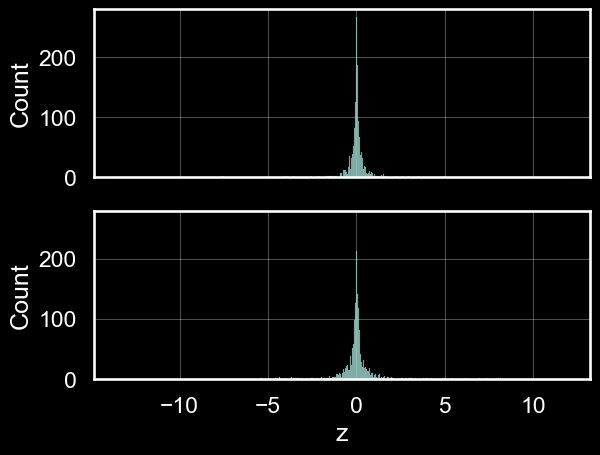

In [102]:
fig,ax = plt.subplots(2,sharex='all',sharey='all')
sns.histplot(df_sensor_one['z'],ax=ax[0])
sns.histplot(df_sensor_two['z'],ax=ax[1])

![Tap Detection Logic](/media/tap_detect.png)

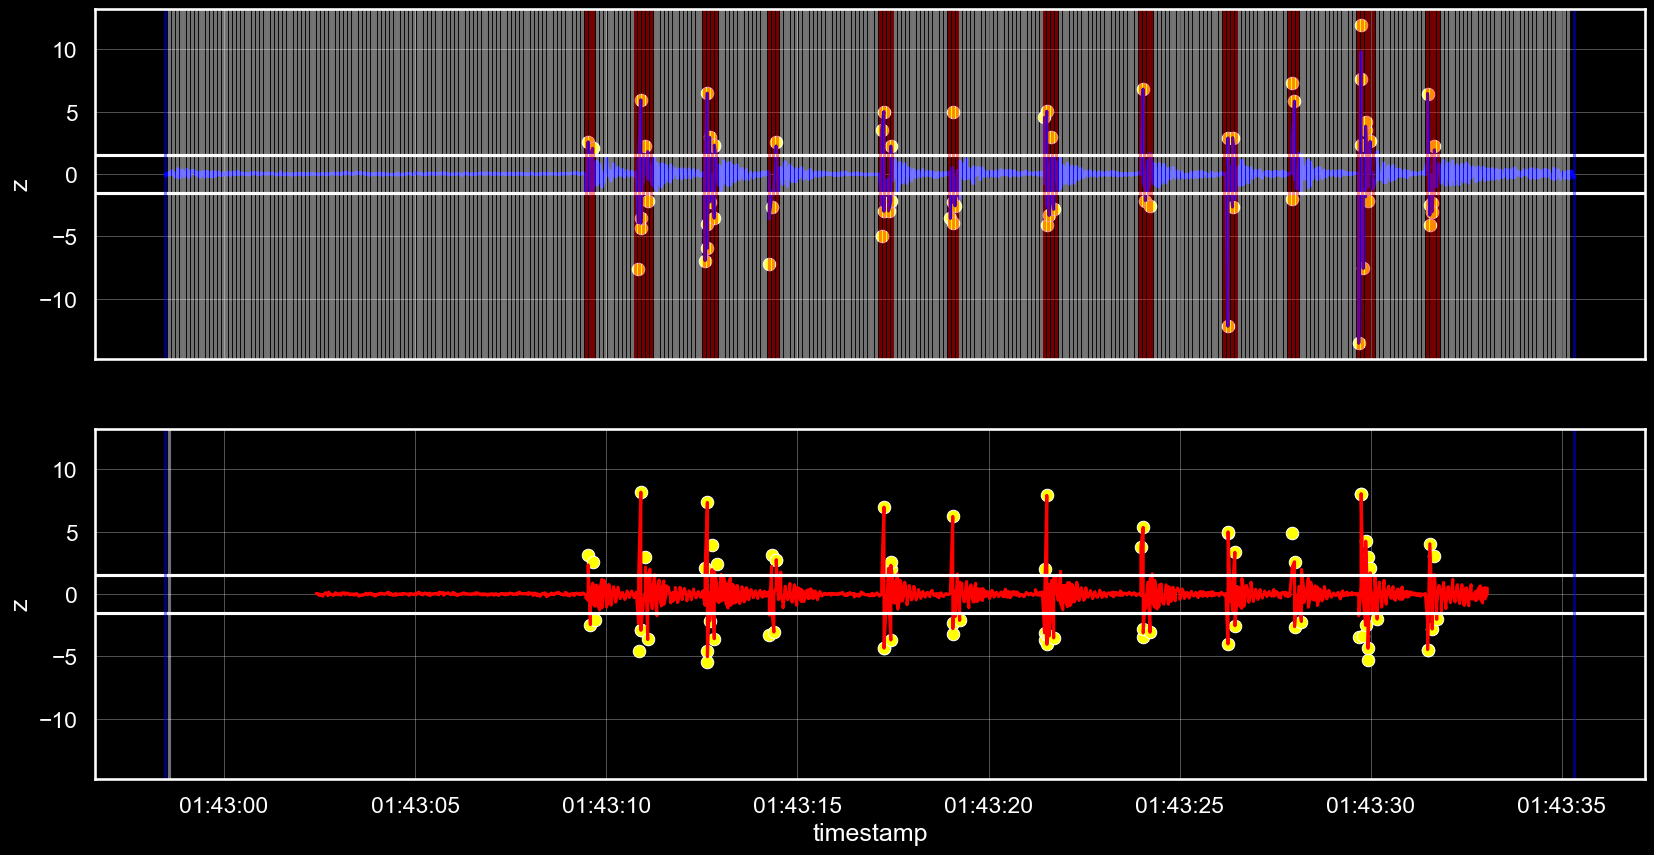

In [103]:
#comparing sliding window approach

window_size = 0.2
stride = 0.2*0.5



fig,ax = plt.subplots(2,figsize = (20,10),sharex='all',sharey='all')

sns.lineplot(x = df_sensor_one.index,y = df_sensor_one['z'],errorbar=None,color="blue",ax=ax[0]) #ci none cuts down on rendering time when using seaborn!!
sns.lineplot(x = df_sensor_two.index,y = df_sensor_two['z'],errorbar=None,color="red",ax=ax[1])

ax[0].axhline(y = 1.5*std_dev_one)
ax[0].axhline(y = -1.5*std_dev_one)

ax[1].axhline(y = 1.5*std_dev_two)
ax[1].axhline(y = -1.5*std_dev_two)

df_new_two = pd.DataFrame(df_sensor_two['z'][~((df_sensor_two['z'] <= 2*std_dev_two)&(df_sensor_two['z'] >= -2*std_dev_two))])
df_new_one = pd.DataFrame(df_sensor_one['z'][~((df_sensor_one['z'] <= 2*std_dev_one)&(df_sensor_one['z'] >= -2*std_dev_one))])


sns.scatterplot(x = df_new_two.index,y = df_new_two['z'],color="yellow",ax=ax[1])
sns.scatterplot(x = df_new_one.index,y = df_new_one['z'],color="yellow",ax=ax[0])


ax[0].axvline(x=df_sensor_one.index[0],alpha=0.450,color='blue')
ax[1].axvline(x=df_sensor_one.index[0],alpha=0.450,color='blue')


old_time = df_sensor_one.index[0]
new_time = df_sensor_one.index[0]+datetime.timedelta(seconds=window_size)

sensor_one_taps = []

while new_time < df_sensor_one.index[-1]:

    window = df_sensor_one[old_time:new_time]['taps']
    if(1 in window.values):
        color = 'red'
        sensor_one_taps.append(old_time+datetime.timedelta(seconds=stride))

    else:
        color = 'white'
    
    ax[0].axvline(x=old_time+datetime.timedelta(seconds=stride),alpha=0.450,color=color)

    if(window.empty):
        break

    new_time += datetime.timedelta(seconds=stride)
    old_time += datetime.timedelta(seconds=stride)

old_time = df_sensor_one.index[0]
new_time = df_sensor_one.index[0]+datetime.timedelta(seconds=0.3)

sensor_two_taps = []

while new_time < df_sensor_one.index[-1]:

    window = df_sensor_two[old_time:new_time]['taps']

    if(1 in window.values):
        color = 'red'
        sensor_two_taps.append(old_time+datetime.timedelta(seconds=stride))

    else:
        color = 'white'
    
    ax[1].axvline(x=old_time+datetime.timedelta(seconds=stride),alpha=0.450,color=color)

    if(window.empty):
        break
    
    new_time += datetime.timedelta(seconds=stride)
    old_time += datetime.timedelta(seconds=stride)


ax[0].axvline(x=df_sensor_one.index[-1],alpha=0.450,color='blue')
ax[1].axvline(x=df_sensor_one.index[-1],alpha=0.450,color='blue')
    

In [104]:
tap_intervals_sensor_one = []
tap_intervals_sensor_two = []

last_reading = sensor_one_taps[0]

for x in range(1,len(sensor_one_taps)):
    readings_diff = sensor_one_taps[x]-sensor_one_taps[x-1]
    if(readings_diff > datetime.timedelta(seconds=stride)):
        interval = [last_reading,sensor_one_taps[x-1]]
        last_reading = sensor_one_taps[x]

        tap_intervals_sensor_one.append(interval)

tap_intervals_sensor_one.append([last_reading, sensor_one_taps[-1]])

last_reading = sensor_two_taps[0]

for x in range(1,len(sensor_two_taps)):
    readings_diff = sensor_two_taps[x]-sensor_two_taps[x-1]
    if(readings_diff > datetime.timedelta(seconds=stride)):
        interval = [last_reading,sensor_two_taps[x-1]]
        last_reading = sensor_two_taps[x]

        tap_intervals_sensor_two.append(interval)

tap_intervals_sensor_two.append([last_reading, sensor_one_taps[-1]])

print(tap_intervals_sensor_two)

IndexError: list index out of range

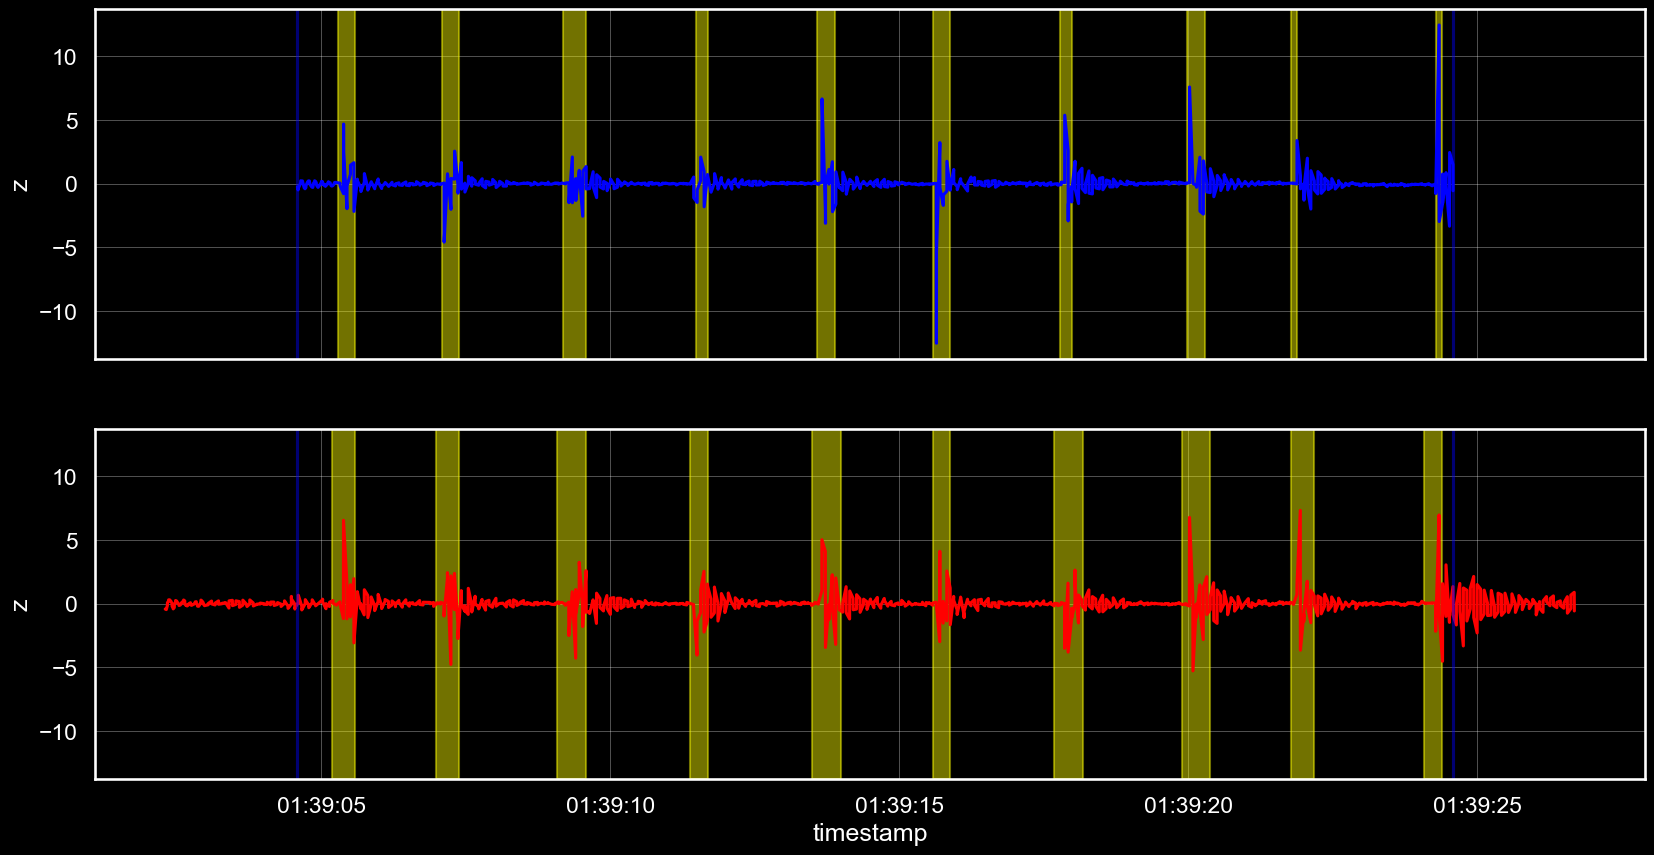

In [ ]:
#plotting all intervals for tsfresh

window_size = 0.2
stride = 0.2*0.5



fig,ax = plt.subplots(2,figsize = (20,10),sharex='all',sharey='all')

sns.lineplot(x = df_sensor_one.index,y = df_sensor_one['z'],errorbar=None,color="blue",ax=ax[0]) #ci none cuts down on rendering time when using seaborn!!
sns.lineplot(x = df_sensor_two.index,y = df_sensor_two['z'],errorbar=None,color="red",ax=ax[1])


df_new_two = pd.DataFrame(df_sensor_two['z'][~((df_sensor_two['z'] <= 2*std_dev_two)&(df_sensor_two['z'] >= -2*std_dev_two))])
df_new_one = pd.DataFrame(df_sensor_one['z'][~((df_sensor_one['z'] <= 2*std_dev_one)&(df_sensor_one['z'] >= -2*std_dev_one))])


ax[0].axvline(x=df_sensor_one.index[0],alpha=0.450,color='blue')
ax[1].axvline(x=df_sensor_one.index[0],alpha=0.450,color='blue')


ax[0].axvline(x=df_sensor_one.index[-1],alpha=0.450,color='blue')
ax[1].axvline(x=df_sensor_one.index[-1],alpha=0.450,color='blue')

for interval in tap_intervals_sensor_one:
    ax[0].axvspan(interval[0],interval[1],color='yellow',alpha=0.45)

for interval in tap_intervals_sensor_two:
    ax[1].axvspan(interval[0],interval[1],color='yellow',alpha=0.45)
    